In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import tensorflow as tf

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)  

# Get current working directory
cwd = os.getcwd()

# Set GPU memory growth, useful only for cuda gpu with computability power 3.5 or higher 
# Allows to only as much GPU memory as needed
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#  try:
    # Currently, memory growth needs to be the same across GPUs
#    for gpu in gpus:
#      tf.config.experimental.set_memory_growth(gpu, True)
#    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
#    print(e)

In [3]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(validation_split=0.2,
                                        rotation_range=10,
                                        width_shift_range=10,
                                        height_shift_range=10,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        fill_mode='constant',
                                        cval=0,
                                        rescale=1./255)
else:
    train_data_gen = ImageDataGenerator(validation_split=0.2,
                                        rescale=1./255)

# Create validation and test ImageDataGenerator objects
valid_data_gen = ImageDataGenerator(rescale=1./255)

Found 1247 images belonging to 20 classes.


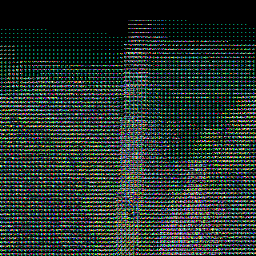

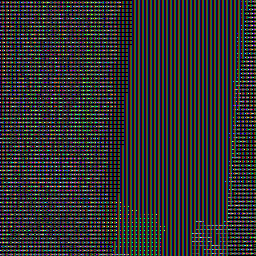

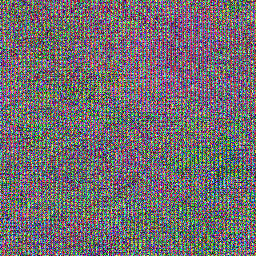

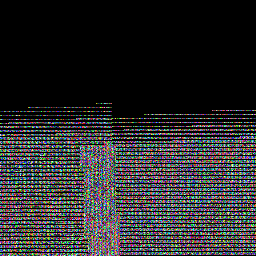

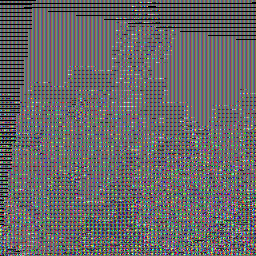

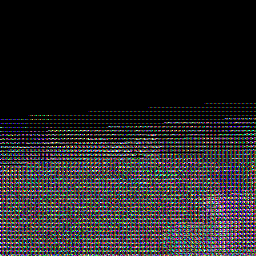

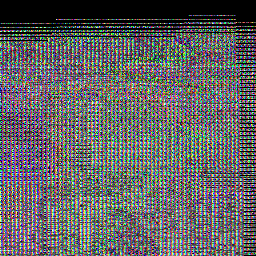

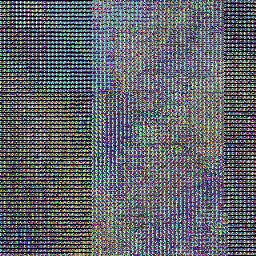

Found 307 images belonging to 20 classes.


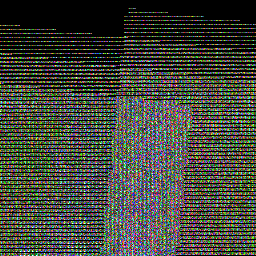

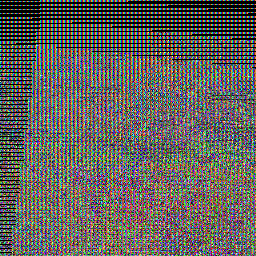

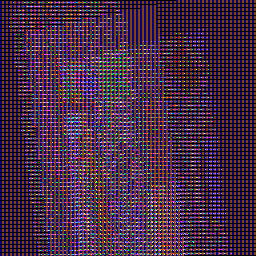

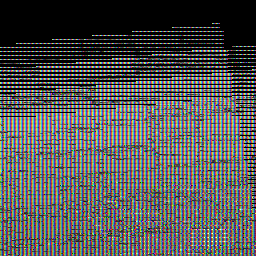

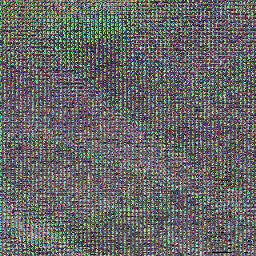

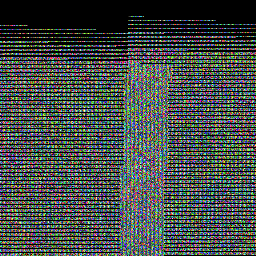

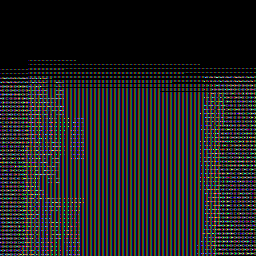

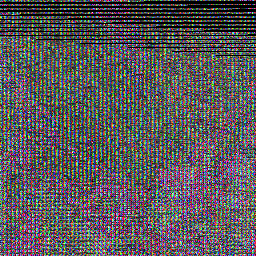

In [16]:
# Create generators to read images from dataset directory
# -------------------------------------------------------
dataset_dir = os.path.join(cwd, 'Classification_Dataset')

# Batch size
bs = 8

# img shape, competition dataset does not have regular shapes, must search a method to solve
img_h = 256
img_w = 256

num_classes=20

decide_class_indices = True
if decide_class_indices:
    class_list = ['owl', # 0
               'galaxy', # 1
               'lightning', # 2
               'wine-bottle', # 3
               't-shirt', # 4
               'waterfall', # 5
               'sword', # 6
               'school-bus', # 7
               'calculator', # 8
               'sheet-music', # 9
               'airplanes', # 10
               'lightbulb', # 11
               'skyscraper', # 12
               'mountain-bike', # 13
               'fireworks', # 14
               'computer-monitor', # 15
               'bear', # 16
               'grand-piano', # 17
               'kangaroo', # 18
               'laptop'] # 19
else:
    classes=None

# Training
training_dir = os.path.join(dataset_dir, 'training')
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               target_size=(img_h, img_w),
                                               batch_size=bs,
                                               classes=class_list,
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset='training',
                                               seed=SEED)  
# targets are directly converted into one-hot vectors

import PIL
from PIL import Image
import numpy as np
import random
#ciclo
#for n_array_image, n_array_labels in train_gen
#     for n_image in n_array_image
n_array_image, n_array_labels = train_gen[random.randrange(156)]
for n_image in n_array_image:
    data = n_image
    data[255, 255] = [255, 0, 0] #provato anche a commentare questo comando ma non cambia
    img = Image.fromarray(data, 'RGB') 
    display(img.resize((256,256), PIL.Image.LANCZOS))

# Validation,
valid_gen = train_data_gen.flow_from_directory(training_dir,
                                               target_size=(img_h, img_w),
                                               batch_size=bs, 
                                               classes=class_list,
                                               class_mode='categorical',
                                               shuffle=False,
                                               subset='validation',
                                               seed=SEED)

n_array_image, n_array_labels = valid_gen[random.randrange(39)]
for n_image in n_array_image:
    data = n_image
    data[255, 255] = [255, 0, 0] #provato anche a commentare questo comando ma non cambia
    img = Image.fromarray(data, 'RGB') 
    display(img.resize((256,256), PIL.Image.LANCZOS))

In [ ]:
# Create Dataset objects
# ----------------------

# Training
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

# Shuffle (Already done in generator..)
# train_dataset = train_dataset.shuffle(buffer_size=len(train_gen))

# Normalize images (Already done in generator..)
#def normalize_img(x_, y_):
#     return tf.cast(x_, tf.float32) / 255., y_

# train_dataset = train_dataset.map(normalize_img)

# 1-hot encoding <- for categorical cross entropy (Already done in generator..)
# def to_categorical(x_, y_):
#     return x_, tf.one_hot(y_, depth=10)

# train_dataset = train_dataset.map(to_categorical)

# Divide in batches (Already done in generator..)
# train_dataset = train_dataset.batch(bs)

# Repeat
# Without calling the repeat function the dataset 
# will be empty after consuming all the images
train_dataset = train_dataset.repeat()

# Validation
# ----------
valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

# Repeat
valid_dataset = valid_dataset.repeat()

In [ ]:
train_gen.class_indices

In [ ]:
# Keras Model subclassing 
# -----------------------

# Please note that there are many ways to implement a CNN
# Here subclassing is used just for teaching purposes, but you
# can simply write every single layer as usual using Model or Sequential..

# Create convolutional block
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv2d = tf.keras.layers.Conv2D(filters=num_filters,
                                             kernel_size=(3, 3),
                                             strides=(1, 1), 
                                             padding='same')
        self.activation = tf.keras.layers.ReLU()  # we can specify the activation function directly in Conv2D
        self.conv2d = tf.keras.layers.Conv2D(filters=num_filters,
                                             kernel_size=(3, 3),
                                             strides=(1, 1), 
                                             padding='same')
        self.activation = tf.keras.layers.ReLU()  # we can specify the activation function directly in Conv2D
        self.pooling = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
        
    def call(self, inputs):
        x = self.conv2d(inputs)
        x = self.activation(x)
        x = self.pooling(x)
        return x

In [ ]:
# Create Model
# ------------

depth = 5
start_f = 8
num_classes = 20

class CNNClassifier(tf.keras.Model):
    def __init__(self, depth, start_f, num_classes):
        super(CNNClassifier, self).__init__()
        
        self.feature_extractor = tf.keras.Sequential()
    
        for i in range(depth):
            self.feature_extractor.add(ConvBlock(num_filters=start_f))
            start_f *= 2
            
        self.flatten = tf.keras.layers.Flatten()
        self.classifier = tf.keras.Sequential()
        self.classifier.add(tf.keras.layers.Dropout(0.2, noise_shape=None, seed=SEED))
        self.classifier.add(tf.keras.layers.Dense(units=512, activation='relu'))
        self.classifier.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))
        
    def call(self, inputs):
        x = self.feature_extractor(inputs)
        x = self.flatten(x)
        x = self.classifier(x)
        return x
    
# Create Model instance
model = CNNClassifier(depth=depth,
                      start_f=start_f,
                      num_classes=num_classes)
# Build Model (Required)
model.build(input_shape=(None, img_h, img_w, 3))

In [ ]:
# Visualize created model as a table
model.feature_extractor.summary()

# Visualize initialized weights
model.weights

In [ ]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
import os
from datetime import datetime

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'classification_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=10)
    callbacks.append(es_callback)


model.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=len(train_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_gen),
          callbacks=callbacks)

# How to visualize Tensorboard

# 1. tensorboard --logdir classification_experiments --port 6066     <- from terminal
# 2. localhost:6066   <- in your browser

In [ ]:
import os
from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [ ]:
from PIL import Image
import numpy as np
#model.load_weights(cwd+'/classification_experiments/CNN_Nov17_17-45-15/ckpts/cp_32.ckpt')  # use this if you want to restore saved model

# Test
test_dir = os.path.join(dataset_dir, 'test')
image_filenames = next(os.walk(test_dir))[2]

results = {}
for image_name in image_filenames:
    file_path = test_dir+'\\'+image_name
    img = Image.open(file_path).convert('RGB')
    img = img.resize((img_w, img_h))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, 0)
    out_softmax = model.predict(x=img_array / 255.)
    prediction = tf.argmax(out_softmax, -1)
    results[image_name] = prediction[0].numpy()
    
create_csv(results)
